## Spam SMS Detection
To build a machine learning model that can effectively classify incoming SMS messages as either spam or non-spam.

#### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer # stemming and lemmatization
import string
from sklearn.feature_extraction.text import TfidfVectorizer # for vectorization
from sklearn.model_selection import train_test_split # splitting training and testing data

# model training
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data.shape

(5572, 5)

In [ ]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


#### Data cleaning
Since Unnamed: 2, Unnamed: 3, Unnamed: 4 have many null values so drop these columns

In [ ]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [ ]:
data.head()


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# renaming the columns
data.rename(columns = {'v1':'target', 'v2':'message'}, inplace=True)

In [ ]:
data.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
label_encoder = LabelEncoder()
data["target"]=label_encoder.fit_transform(data["target"])

In [ ]:
data.head()

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# checkign for duplicated values
print(data.duplicated().any())
print(data.duplicated().sum())

True
403


In [ ]:
# removing duplicated values
data = data.drop_duplicates(keep='first')
print(data.duplicated().sum())

0


### EDA and Visualization

In [ ]:
data['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x78173b749d80>,
 [Text(-1.0144997251399075, 0.42519443516002464, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001339, '87.37'),
  Text(0.5533635081542612, -0.23192418555038377, '12.63')])

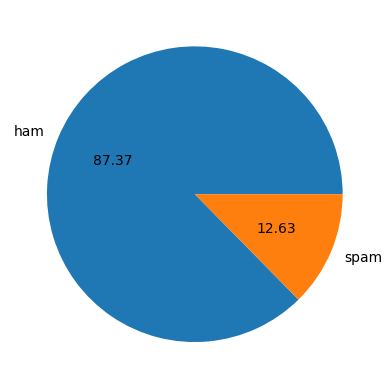

In [ ]:
# using piechart for visualization
plt.pie(data['target'].value_counts(), labels=['ham','spam'], autopct='%.2f')

In [ ]:
# Data is imbalanced as there are many number of ham and fewer number of spam

In [ ]:
data['characters'] = data['message'].apply(len) # gives the length of each message

In [ ]:
data['num_words'] = data['message'].apply(lambda x: len(nltk.word_tokenize(x)))

In [ ]:
data.head()

,target,message,characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [ ]:
data['num_sentence'] = data['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [ ]:
data.describe()

,target,characters,num_words,num_sentence
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


<Axes: xlabel='characters', ylabel='Count'>

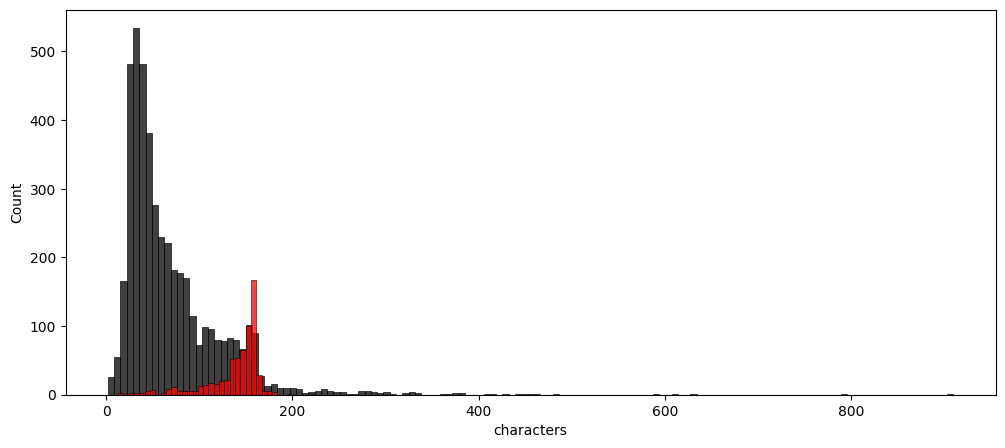

In [ ]:
# plotting histogram to visualize ham and spam messages
plt.figure(figsize=(12,5))
sns.histplot(data[data['target']==0]['characters'], color='black')
sns.histplot(data[data['target']==1]['characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

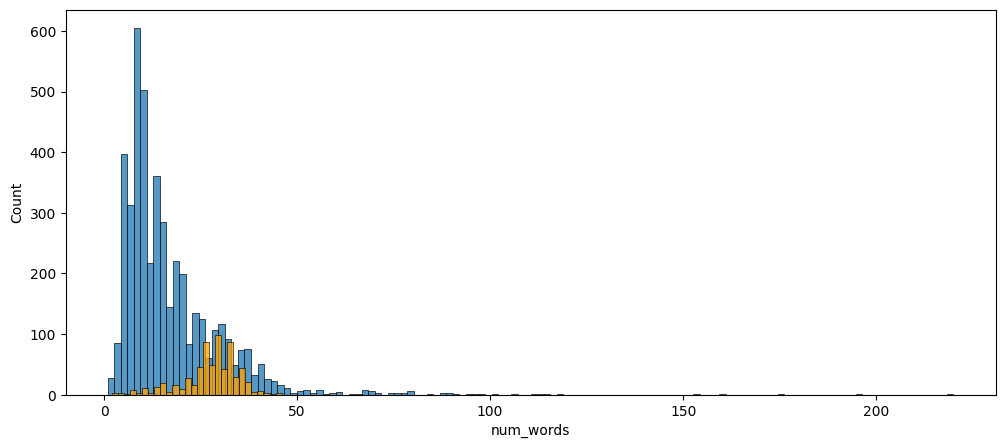

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(data[data['target']==0]['num_words'])
sns.histplot(data[data['target']==1]['num_words'], color='orange')

<Axes: xlabel='num_sentence', ylabel='Count'>

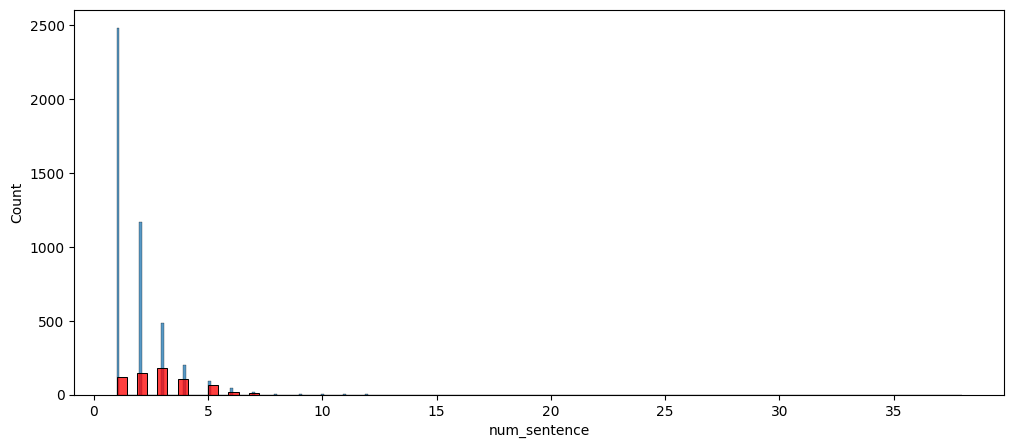

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(data[data['target']==0]['num_sentence'])
sns.histplot(data[data['target']==1]['num_sentence'], color='red')

<ipython-input-37-ee253d3168c8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


<Axes: >

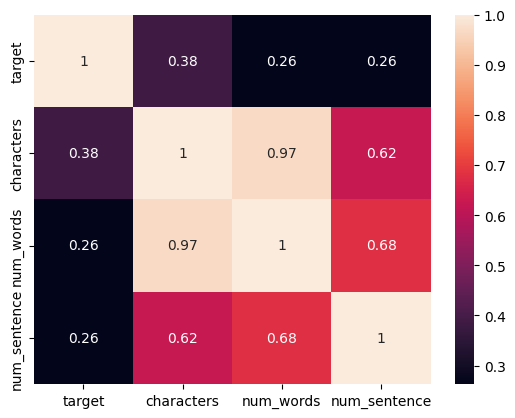

In [ ]:
# plotting heatmap for correlation
sns.heatmap(data.corr(), annot=True)

#### Text Preprocessing

In [ ]:
stopwords.words('english')
string.punctuation
ps= PorterStemmer()

In [ ]:
def pre_process(text):
  text=text.lower() #change to lowercase
  text=nltk.word_tokenize(text)

  y = []
  for i in text:
    if i.isalnum(): # if i is alpha numeric
      y.append(i)
    y.clear()

  for i in text:# removing stopwords and punctuations
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)

  text =y[:] # cloning since list are mutuable datatypes
  y.clear()

  for i in text:
    y.append(ps.stem(i))# stemming


  return " ".join(y)



In [ ]:
pre_process( "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

"'m gon na home soon n't want talk stuff anymor tonight k 've cri enough today"

In [ ]:
data['Preprocessed_text'] = data['message'].apply(pre_process)

In [ ]:
data.head()

,target,message,characters,num_words,num_sentence,Preprocessed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi .. avail bugi n great wo...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah n't think goe usf live around though


In [ ]:
tfidf= TfidfVectorizer()
X = tfidf.fit_transform(data['Preprocessed_text']).toarray()

### Spliting train and test data

In [ ]:
Y = data['target']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

### Model Building and Training

In [ ]:
# Using NaiveBayes
MnB = MultinomialNB()


In [ ]:
MnB.fit(X_train, y_train)
y_pred = MnB.predict(X_test)

In [ ]:
print('Accuracy score of Multinomial NB is:\n ',accuracy_score(y_test,y_pred))
print('Confusion Matrix of Multinomial NB is:\n ',confusion_matrix(y_test,y_pred))
print('Classification Report of the Multinomial NB is:\n',classification_report(y_test,y_pred))

Accuracy score of Multinomial NB is:
  0.9661508704061895
Confusion Matrix of Multinomial NB is:
  [[889   0]
 [ 35 110]]
Classification Report of the Multinomial NB is:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       1.00      0.76      0.86       145

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.96      1034



In [ ]:
# using logistic regression
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred1 = LR_model.predict(X_test)

In [ ]:
print('Accuracy score of logistic regression is:\n ',accuracy_score(y_test,y_pred1))
print('Confusion Matrix of logistic regression is:\n ',confusion_matrix(y_test,y_pred1))
print('Classification Report of the logistic regression is:\n',classification_report(y_test,y_pred1))

Accuracy score of logistic regression is:
  0.9535783365570599
Confusion Matrix of logistic regression is:
  [[883   6]
 [ 42 103]]
Classification Report of the logistic regression is:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       889
           1       0.94      0.71      0.81       145

    accuracy                           0.95      1034
   macro avg       0.95      0.85      0.89      1034
weighted avg       0.95      0.95      0.95      1034



In [ ]:
# Using Support Vector Machine
svm_model = svm.SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred2 = LR_model.predict(X_test)

In [ ]:
print('Accuracy score ofsvm is:\n ',accuracy_score(y_test,y_pred2))
print('Confusion Matrix of svm is:\n ',confusion_matrix(y_test,y_pred2))
print('Classification Report of the svm is:\n',classification_report(y_test,y_pred2))

Accuracy score ofsvm is:
  0.9535783365570599
Confusion Matrix of svm is:
  [[883   6]
 [ 42 103]]
Classification Report of the svm is:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       889
           1       0.94      0.71      0.81       145

    accuracy                           0.95      1034
   macro avg       0.95      0.85      0.89      1034
weighted avg       0.95      0.95      0.95      1034



Among these training algorithms the accuracy of logistic regression and SVM are higher. Thus, this is the best model to predict spam messages.